In [3]:
#import libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Load cleaned data
df = pd.read_csv('amazon_sales_cleaned.csv')
df['order_date'] = pd.to_datetime(df['order_date'])


# 1. Descriptive Statistics
# ------------------------------
print("Descriptive statistics for numeric columns:\n")
display(df.describe())

Descriptive statistics for numeric columns:



,order_id,order_date,product_id,price,discount_percent,quantity_sold,rating,review_count,discounted_price,total_revenue,year,month,day,day_of_week
count,50000.000000,50000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.0000,50000.000000,50000.000000
mean,25000.500000,2022-12-31 10:47:16.800000256,2986.848740,252.507260,13.340700,2.999400,2.996316,249.329280,218.886566,654.978488,2022.501480,6.5044,15.790820,3.018120
min,1.000000,2022-01-01 00:00:00,1000.000000,5.010000,0.000000,1.000000,1.000000,0.000000,3.530000,3.840000,2022.000000,1.0000,1.000000,0.000000
25%,12500.750000,2022-07-02 00:00:00,1983.000000,127.840000,5.000000,2.000000,2.000000,125.000000,109.680000,240.320000,2022.000000,4.0000,8.000000,1.000000
50%,25000.500000,2023-01-02 00:00:00,2983.000000,252.970000,10.000000,3.000000,3.000000,250.000000,215.805000,505.410000,2023.000000,7.0000,16.000000,3.000000
75%,37500.250000,2023-07-02 00:00:00,3989.000000,376.335000,20.000000,4.000000,4.000000,374.000000,322.702500,968.970000,2023.000000,9.0000,23.000000,5.000000
max,50000.000000,2023-12-31 00:00:00,4999.000000,499.990000,30.000000,5.000000,5.000000,499.000000,499.910000,2061.945000,2023.000000,12.0000,31.000000,6.000000
std,14433.901067,NaN,1156.374535,143.025544,9.850694,1.415401,1.154295,144.251981,127.317681,519.356606,0.500003,3.4360,8.799767,1.999068


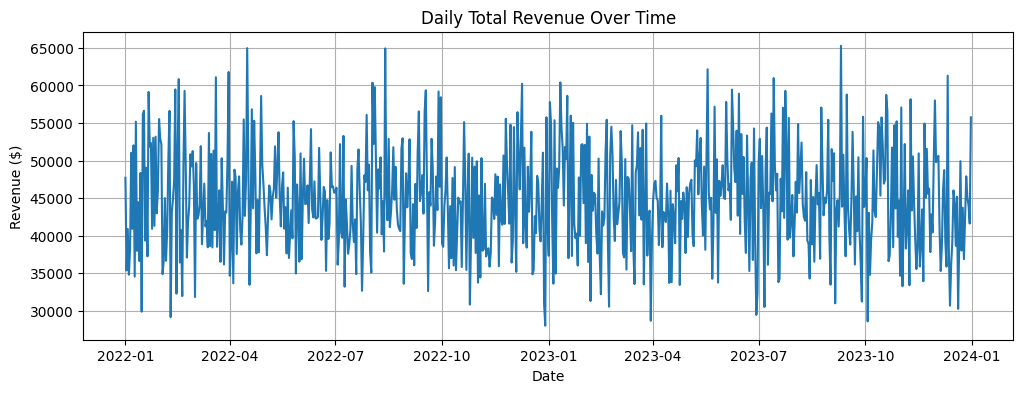

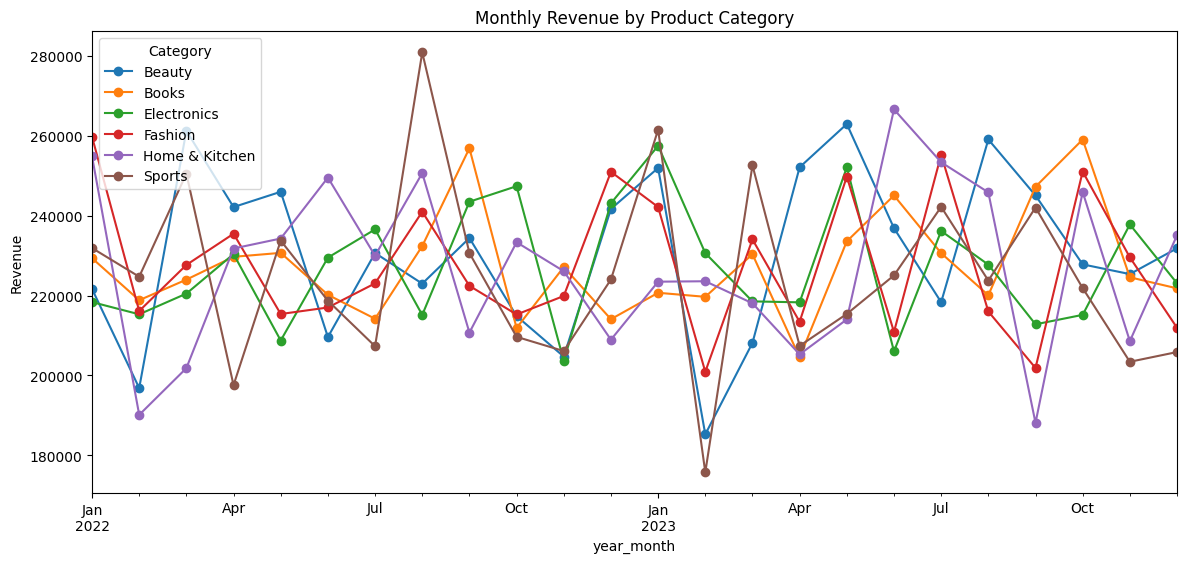

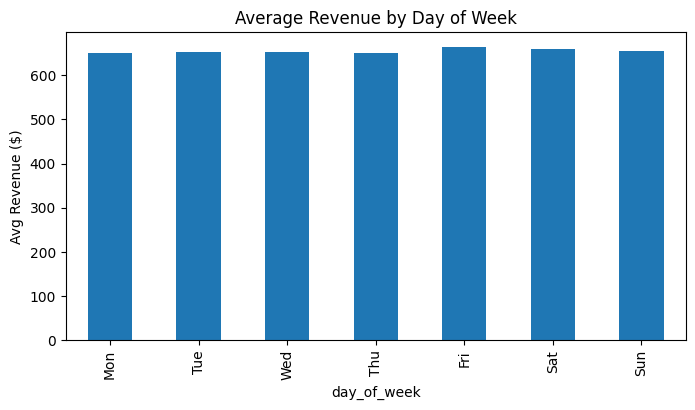

In [4]:
# 2. Temporal Trends 

# Daily total revenue
daily_revenue = df.groupby('order_date')['total_revenue'].sum().reset_index()
plt.figure(figsize=(12,4))
plt.plot(daily_revenue['order_date'], daily_revenue['total_revenue'])
plt.title('Daily Total Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue ($)')
plt.grid(True)
plt.show()

# Monthly aggregated sales by category
df['year_month'] = df['order_date'].dt.to_period('M')
monthly_category = df.groupby(['year_month', 'product_category'])['total_revenue'].sum().unstack().fillna(0)
monthly_category.plot(figsize=(14,6), marker='o')
plt.title('Monthly Revenue by Product Category')
plt.ylabel('Revenue')
plt.legend(title='Category')
plt.show()

# Day-of-week analysis
dow_revenue = df.groupby('day_of_week')['total_revenue'].mean()
plt.figure(figsize=(8,4))
dow_revenue.plot(kind='bar')
plt.xticks(ticks=range(7), labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.title('Average Revenue by Day of Week')
plt.ylabel('Avg Revenue ($)')
plt.show()

